In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Device setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


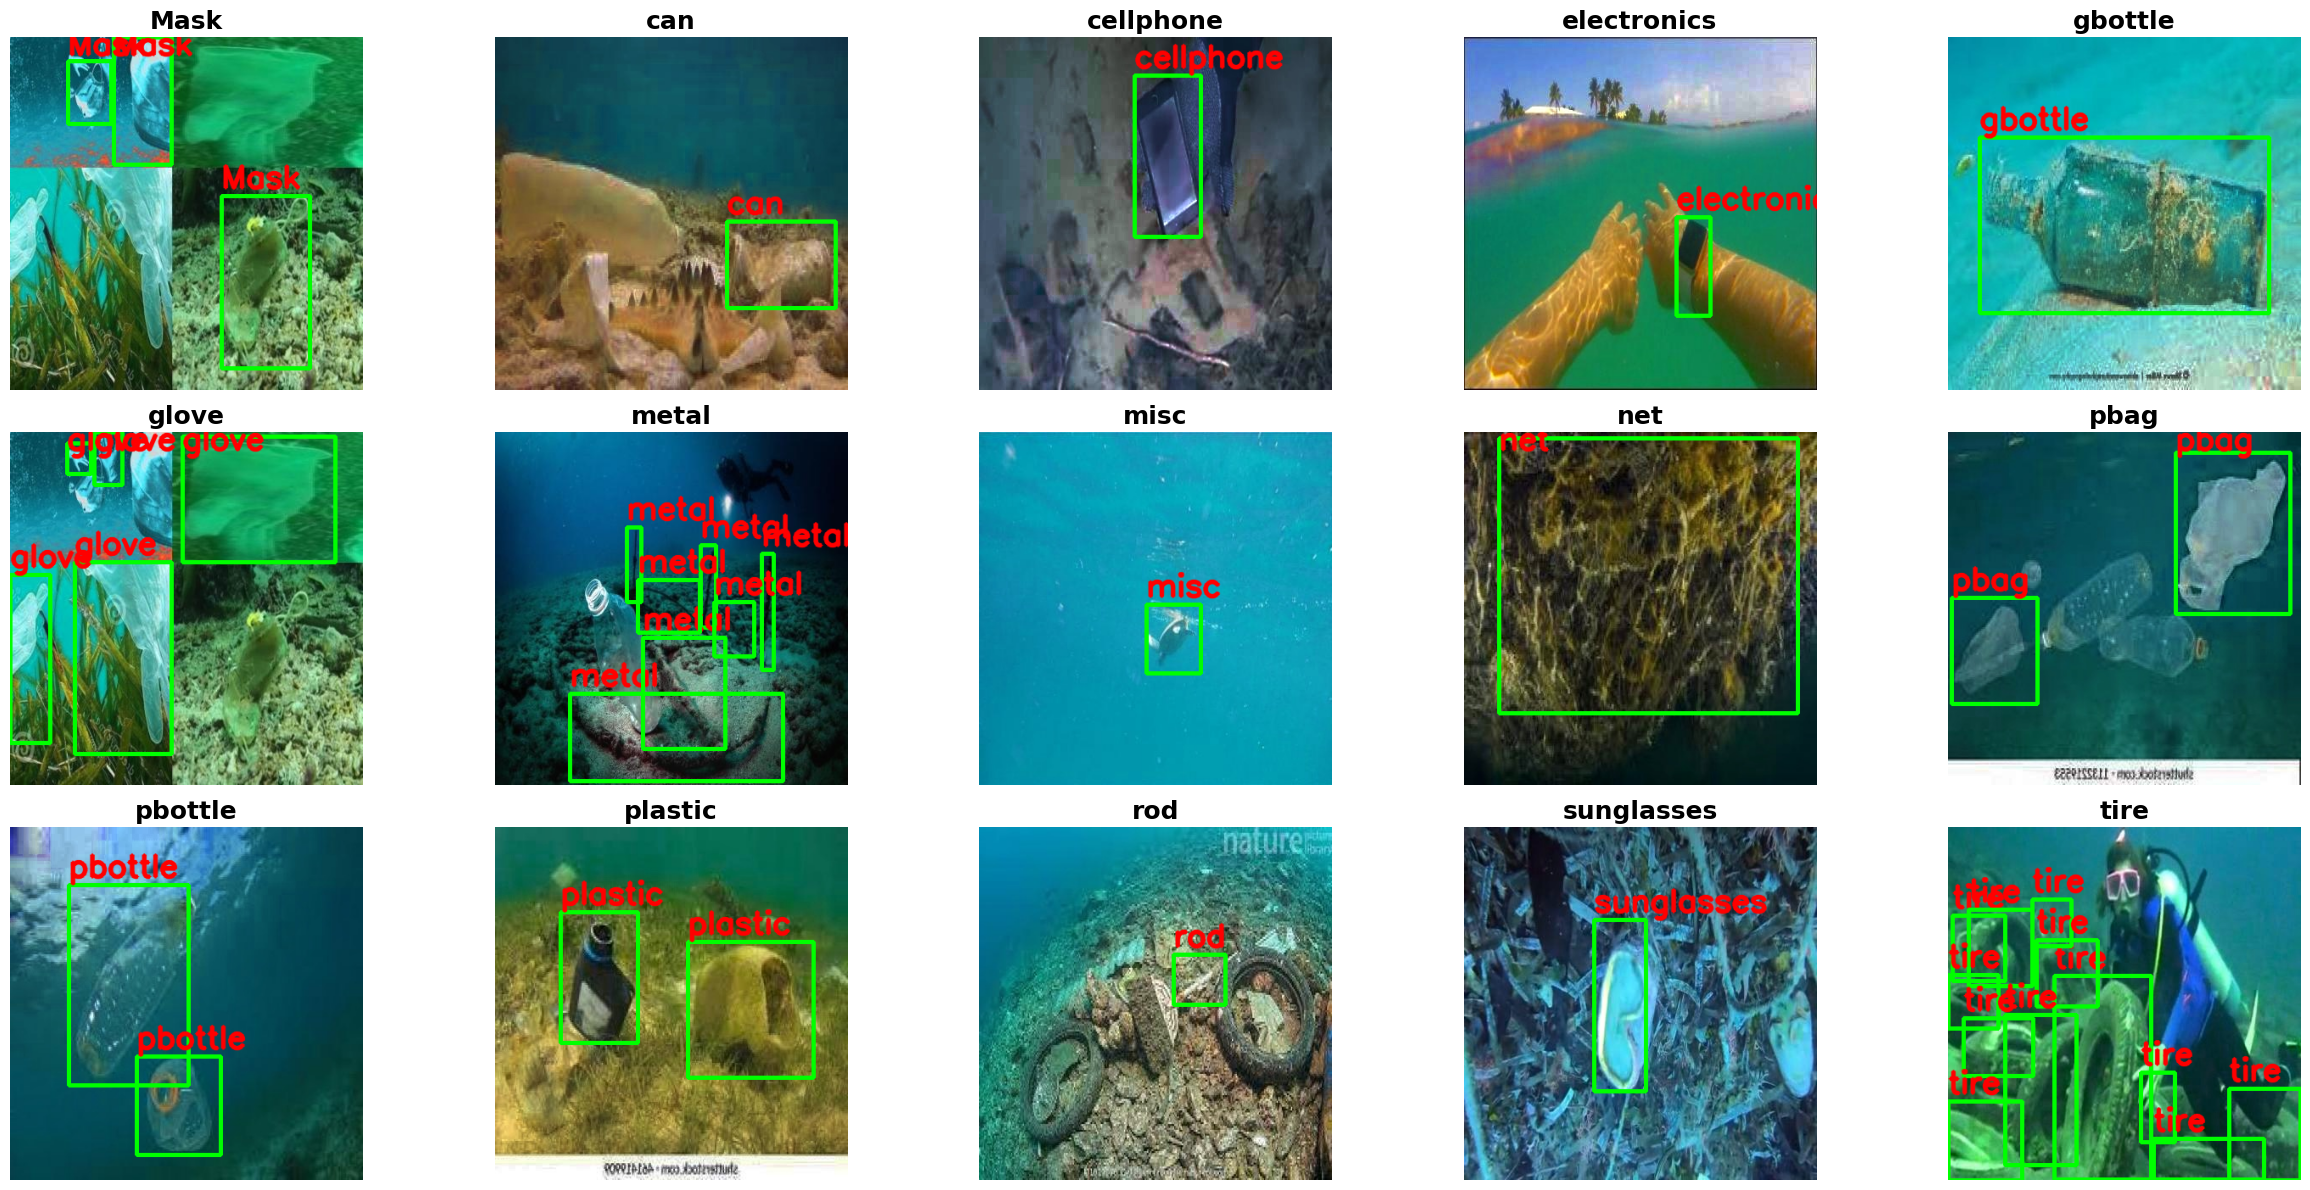

In [12]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

# Define your 15 classes
CLASS_NAMES = ['Mask', 'can', 'cellphone', 'electronics', 'gbottle', 'glove',
               'metal', 'misc', 'net', 'pbag', 'pbottle', 'plastic',
               'rod', 'sunglasses', 'tire']

class UnderwaterYoloDataset(Dataset):
    def __init__(self, root_dir):
        self.img_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.imgs = sorted(os.listdir(self.img_dir))
        self.labels = sorted(os.listdir(self.label_dir))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        label_path = os.path.join(self.label_dir, self.labels[idx])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, x, y, bw, bh = map(float, parts)
                cls = int(cls)

                x1 = int((x - bw / 2) * w)
                y1 = int((y - bh / 2) * h)
                x2 = int((x + bw / 2) * w)
                y2 = int((y + bh / 2) * h)

                boxes.append([x1, y1, x2, y2])
                labels.append(cls)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) if boxes.size(0) > 0 else torch.tensor([])

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': area,
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }

        # Normalize and convert to tensor, shape CxHxW
        img = torch.tensor(img / 255., dtype=torch.float32).permute(2, 0, 1)

        return img, target


# Example usage and visualization:

# Path to your train folder (adjust if needed)
root_dir = "/kaggle/input/underwater-plastic-pollution-detection/underwater_plastics/train"

dataset = UnderwaterYoloDataset(root_dir)

# Collect one image per class to visualize
seen_classes = set()
images_per_class = {}

for i in range(len(dataset)):
    img, target = dataset[i]
    labels = target['labels'].tolist()

    for cls in labels:
        if cls not in seen_classes:
            seen_classes.add(cls)
            images_per_class[cls] = (img.permute(1, 2, 0).numpy(), target['boxes'].numpy(), labels)
    if len(seen_classes) == 15:
        break

# Plot 3 rows x 5 cols grid
fig, axs = plt.subplots(3, 5, figsize=(25, 12))
axs = axs.flatten()

for i in range(15):
    ax = axs[i]
    if i not in images_per_class:
        ax.axis('off')
        continue

    img, boxes, classes = images_per_class[i]
    img = (img * 255).astype(np.uint8)

    for box, cls in zip(boxes, classes):
        if cls != i:
            continue
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
        cv2.putText(img, CLASS_NAMES[cls], (x1, max(y1 - 10, 20)),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 3, cv2.LINE_AA)

    ax.imshow(img)
    ax.set_title(CLASS_NAMES[i], fontsize=18, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [13]:
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# Use ResNet101-FPN as a stronger backbone
def get_custom_maskrcnn(num_classes):
    # Pretrained ResNet101 + FPN
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)

    # Create the Mask R-CNN model
    model = MaskRCNN(backbone, num_classes=num_classes)

    return model


In [14]:
import torch.nn as nn

# Convolutional Block Attention Module (CBAM)
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )

        self.sigmoid_channel = nn.Sigmoid()
        self.sigmoid_spatial = nn.Sigmoid()

        self.spatial = nn.Conv2d(2, 1, kernel_size=7, stride=1, padding=3, bias=False)

    def forward(self, x):
        # Channel attention
        avg_out = self.shared(self.avg_pool(x))
        max_out = self.shared(self.max_pool(x))
        channel_out = self.sigmoid_channel(avg_out + max_out)
        x = x * channel_out

        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_input = torch.cat([avg_out, max_out], dim=1)
        spatial_out = self.sigmoid_spatial(self.spatial(spatial_input))

        return x * spatial_out


In [15]:
class MaskRCNNWithCBAM(MaskRCNN):
    def __init__(self, num_classes):
        backbone = resnet_fpn_backbone('resnet101', pretrained=True)
        super().__init__(backbone, num_classes=num_classes)
        self.cbam = CBAM(256)  # Assuming FPN output channels

    def forward(self, images, targets=None):
        features = self.backbone(images.tensors)
        # Add CBAM to each feature map in FPN
        features = {k: self.cbam(v) for k, v in features.items()}
        return super().forward(images, targets)


In [16]:
num_classes = 16  # 15 waste classes + background
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MaskRCNNWithCBAM(num_classes=num_classes).to(device)


In [17]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)


In [18]:
from torch.utils.data import DataLoader

# Required for batching variable-length annotations
def collate_fn(batch):
    return tuple(zip(*batch))

# Create Datasets
train_dataset = UnderwaterYoloDataset("/kaggle/input/underwater-plastic-pollution-detection/underwater_plastics/train")
valid_dataset = UnderwaterYoloDataset("/kaggle/input/underwater-plastic-pollution-detection/underwater_plastics/valid")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


In [20]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# Define a simple CBAM block
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, relu=True, bn=True):
        super().__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size,
                              stride=stride, padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes) if bn else None
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        if self.relu:
            x = self.relu(x)
        return x

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared_MLP = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_MLP(self.avg_pool(x))
        max_out = self.shared_MLP(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        assert kernel_size in (3, 7), "kernel size must be 3 or 7"
        padding = 3 if kernel_size == 7 else 1

        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv(x_cat)
        return self.sigmoid(x_out)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        out = x * self.channel_attention(x)
        out = out * self.spatial_attention(out)
        return out

# Custom Mask R-CNN with CBAM applied to FPN feature maps
class MaskRCNNWithCBAM(MaskRCNN):
    def __init__(self, num_classes):
        # Load the standard Mask R-CNN with ResNet50-FPN backbone
        backbone = resnet_fpn_backbone('resnet50', pretrained=True)

        # Initialize parent MaskRCNN
        super().__init__(backbone, num_classes)

        # Create a CBAM module for each FPN layer's output channel size
        # FPN outputs typically: ['0', '1', '2', '3', 'pool'] keys, channels = 256
        self.cbam_modules = nn.ModuleDict()
        for name, _ in backbone.body.named_children():
            pass  # just to see backbone body layers, but CBAM is for FPN features below

        # FPN features keys are usually: ['0', '1', '2', '3', 'pool']
        # All with 256 channels for resnet50-FPN
        self.fpn_feature_names = ['0', '1', '2', '3', 'pool']
        for feat_name in self.fpn_feature_names:
            self.cbam_modules[feat_name] = CBAM(256)

    def forward(self, images, targets=None):
        # images is a list of tensors [C,H,W]

        # Extract features using backbone
        features = self.backbone.body(torch.stack(images))  # backbone body output

        # Backbone's FPN expects a dict input and returns dict output, so use self.backbone.fpn:
        features = self.backbone.fpn(features)

        # Apply CBAM on each feature map
        for name in features.keys():
            if name in self.cbam_modules:
                features[name] = self.cbam_modules[name](features[name])

        # Now call the ROI heads etc with these features
        if self.training:
            if targets is None:
                raise ValueError("targets should not be None in training mode")
            return self.roi_heads(features, images, targets)
        else:
            return self.roi_heads(features, images)



In [21]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Prepare optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_train_loss += losses.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in valid_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_val_loss += losses.item()

            outputs = model(images)
            for output, target in zip(outputs, targets):
                pred_labels = output['labels'].cpu().numpy()
                true_labels = target['labels'].cpu().numpy()
                correct += (pred_labels == true_labels[:len(pred_labels)]).sum()
                total += len(true_labels)

    avg_val_loss = total_val_loss / len(valid_loader)
    val_acc = correct / total if total > 0 else 0

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f} | Val Acc = {val_acc:.4f}")

    lr_scheduler.step()


Epoch 1/10:   0%|          | 0/1814 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'tensors'